<a href="https://colab.research.google.com/github/AmYongg/git/blob/master/cnn_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
!ls -l

total 360428
-rw-r--r-- 1 root root 255876408 Oct 14 07:02 2-basic-cnn.h5
drwx------ 5 root root      4096 Oct 14 05:26 drive
drwxr-xr-x 1 root root      4096 Oct  8 13:45 sample_data
drwxr-xr-x 2 root root     36864 Oct 14 05:30 test_data
drwxr-xr-x 2 root root     94208 Oct 14 05:30 training_data
-rw------- 1 root root 113023590 Oct 14 05:30 training_data.zip
drwxr-xr-x 2 root root     36864 Oct 14 05:30 validation_data


In [3]:
# !cp ./drive/MyDrive/training_data.zip .

In [4]:
# !unzip training_data.zip

In [5]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [6]:
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)


In [7]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

(150, 150, 3)


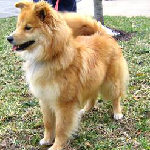

In [8]:
print(train_imgs[1500].shape)
array_to_img(train_imgs[1500])

In [9]:
batch_size = 50
num_classes = 2
epochs = 100
input_shape = (150, 150, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505])

['dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat'] [1 1 1 0 0 1 1 0 1 0]


# 이미지 증강

In [10]:
from keras.preprocessing.image import ImageDataGenerator

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=30,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

In [12]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
type(train_datagen)

keras.preprocessing.image.ImageDataGenerator

In [14]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=32)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=16)

input_shape = (150, 150, 3)

In [15]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

### Model Case I 

In [16]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding="same",
                 input_shape=input_shape))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        9280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       7

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer= 'ADAM', # optimizers.RMSprop(lr=0.0001)
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        9280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       7

In [19]:
history = model.fit_generator(train_generator,  epochs=epochs,
                              validation_data=val_generator,  verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
94/94 [==============================] - 23s 217ms/step - loss: 0.8539 - accuracy: 0.5123 - val_loss: 0.6926 - val_accuracy: 0.5300
Epoch 2/100
94/94 [==============================] - 21s 218ms/step - loss: 0.6891 - accuracy: 0.5573 - val_loss: 0.6825 - val_accuracy: 0.5690
Epoch 3/100
94/94 [==============================] - 20s 212ms/step - loss: 0.6832 - accuracy: 0.5623 - val_loss: 0.6806 - val_accuracy: 0.5610
Epoch 4/100
94/94 [==============================] - 20s 216ms/step - loss: 0.6749 - accuracy: 0.5897 - val_loss: 0.6771 - val_accuracy: 0.5700
Epoch 5/100
94/94 [==============================] - 20s 213ms/step - loss: 0.6678 - accuracy: 0.5930 - val_loss: 0.6609 - val_accuracy: 0.5860
Epoch 6/100
94/94 [==============================] - 20s 212ms/step - loss: 0.6726 - accuracy: 0.5987 - val_loss: 0.6755 - val_accuracy: 0.5690
Epoch 7/100
94/94 [==============================] - 21s 220ms/step - loss: 0.6698 - accuracy: 0.5917 - val_loss: 0.6625 - val_accuracy:

In [20]:
# history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
#                     validation_data=(validation_imgs_scaled, validation_labels_enc),
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1)

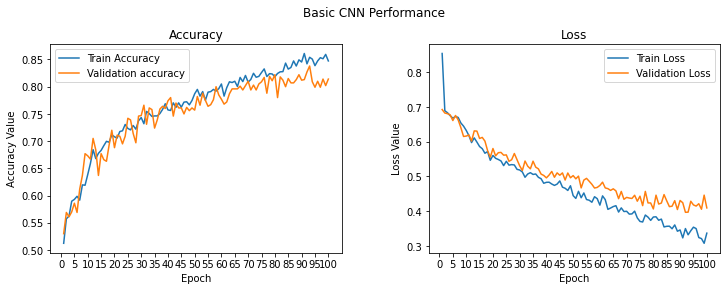

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation accuracy')
ax1.set_xticks(np.arange(0, 101, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [22]:
model.save('3-aug-cnn.h5')

In [23]:
# from google.colab import drive
# drive.mount('/content/drive')